# Predicting temperatures in the future

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
# Change this address to re-run the notebook locally
folder_name = '../data/kaggle_climate/'

In [3]:
# Read the data (warning: a 500 Mb file)
df = pd.read_csv(folder_name + 'GlobalLandTemperaturesByCity.csv')
df = df.assign(Date = pd.to_datetime(df.dt))
df = (df
      .assign(Year = df.Date.dt.year)
      .assign(Month = df.Date.dt.month)
     )
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude', 'Date', 'Year', 'Month'],
      dtype='object')

In [4]:
# Cities to process:
city_list = ['Kyzyl', 'Blagoveshchensk', 'Hailar', 'Nehe']

## Seasonal trend + linear trend

Let's assume that the average temperature for every month $t$ can be represented as $t(y,m) = t_m(m) + t_t(y)$, where $y$ is the year, and $m$ is the month (a number from 1 to 12). That is, let's assume that there's a yearly pattern, and also a linear trend on top of it.

And let's try a quadratic function for the yearly trend: $t_y(y) = a + by + cy^2$. Linear trend would also work, but we've seen in the previous exercise that all these cities (and the entire country of Mongolia, which is the closest country to where they are located) had an acceleration of climate change in last 2-3 decades. So a linear trend over last 100 years would be likely to understate the warming.

The problem with polynomial fits though is that they explode at infinity, and are horrible for extrapolating. Ideally, we would like to sample from some family of reasonable climate models, but for now, let's try a quadratic trend.

In [5]:
# Prep a dataframe:
earliest_date = pd.to_datetime('1900-01-01')
latest_date = pd.to_datetime('2013-01-01')
dfc = (df
       .query('City in @city_list & Date >= @earliest_date & Date < @latest_date')       
      )

In [6]:
# Dummy variable creator (for months)

def add_dummy_months(df):
    # Adds dummy variables for months
    for i in range(12):
        df[f"m{i+1:02d}"] = (df.Date.dt.month == (i+1)).astype(int)
    return df

add_dummy_months(pd.DataFrame({'Date' : pd.date_range('1966-11-01', '1967-02-01', freq=pd.offsets.MonthBegin(1))}))

,Date,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1966-11-01,0,0,0,0,0,0,0,0,0,0,1,0
1,1966-12-01,0,0,0,0,0,0,0,0,0,0,0,1
2,1967-01-01,1,0,0,0,0,0,0,0,0,0,0,0
3,1967-02-01,0,1,0,0,0,0,0,0,0,0,0,0


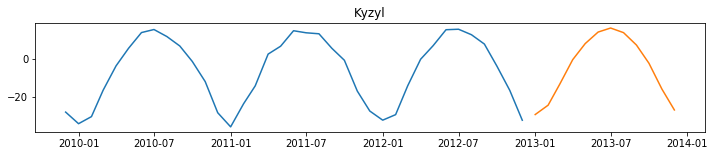

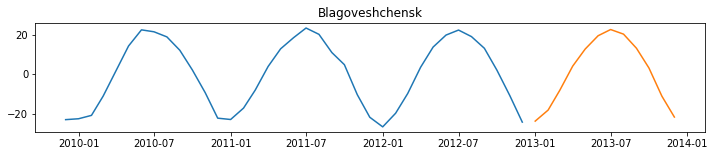

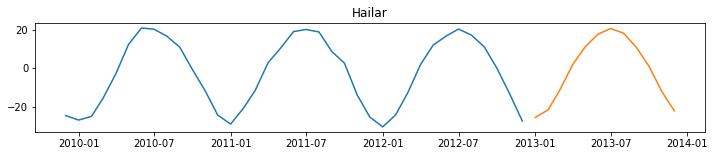

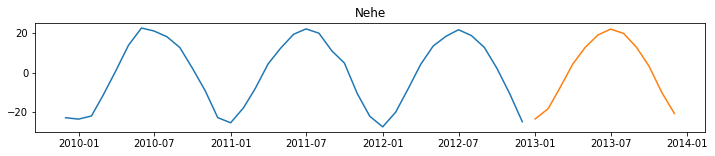

In [7]:
# Fit, and output as a new dataframe

def predict_climate(dfc, city, first_day, last_day):
    """ Extrapolate from 20 centry temp data for CITY into years from FIRST_DAY to LAST_DAY """
    # Just in case, only leave 20th century:
    # (It makes it runnable on all cities from the set)
    safe_date_left = pd.to_datetime('1900-01-01')
    safe_date_right = pd.to_datetime('2013-01-01')
    dfc = (dfc
           .query('Date >= @safe_date_left & Date < @safe_date_right')
           .query('AverageTemperature.notna()', engine='python') # Just in case, a safeguard
          )
    
    prediction_first_day = pd.to_datetime(first_day)
    prediction_last_day = pd.to_datetime(last_day)

    target_days = pd.DataFrame({'Date': pd.date_range(prediction_first_day, 
                                                  prediction_last_day, 
                                                  freq=pd.offsets.MonthBegin(1))})
    target_days['Year'] = target_days.Date.dt.year
    target_days = add_dummy_months(target_days)
    target_days['Y2'] = np.square(target_days.Year)
    
    view = dfc.query('City == @city').copy()
    view = add_dummy_months(view)
    view['Y2'] = np.square(view.Year)
    
    X = view.iloc[:, [i for i in range(view.shape[1]) if view.columns[i] in target_days.columns]]
    X = X.drop(columns=['Date']).values
    y = view.AverageTemperature.values
    
    reg = LinearRegression().fit(X, y)
    out = reg.predict(target_days.drop(columns=['Date']).values)
    return pd.DataFrame({'Date' : target_days.Date, 'AverageTemperature': out})


for i_city, city in enumerate(city_list):
    prediction = predict_climate(dfc, city, '2013-01-01', '2013-12-01')
        
    plot_range_left = max(dfc.Date) - pd.DateOffset(years=3)
    view = dfc.query('City == @city & Date >= @plot_range_left')    
    
    plt.figure(figsize=(12,2))
    plt.plot(view.Date, view.AverageTemperature)
    plt.plot(prediction.Date, prediction.AverageTemperature)
    #plt.legend(labels=[city], loc='upper left', frameon=False)    
    plt.title(city)

### Some sense-checks

Let's predict several years, and look at how mean and max temperatures change.

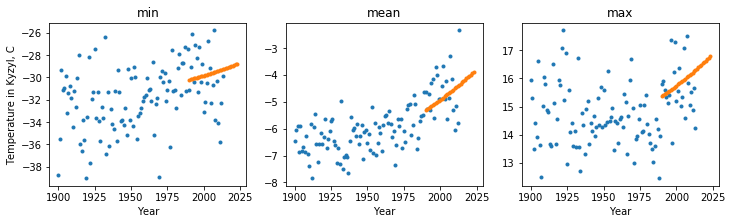

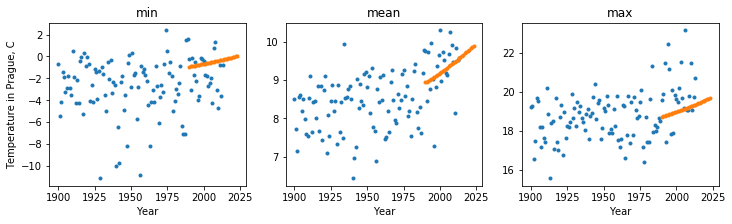

In [8]:
def plot_high_temps(dfc, city):
    # Utility function to make troubleshooting plots    
    prediction = predict_climate(dfc, city, '1990-01-01', '2023-12-01')
    funs = ['min', 'mean', 'max']
    plt.figure(figsize=(12,3))
    for i,fun in enumerate(funs):
        plt.subplot(1,3,i+1)
        past = dfc.query("City == @city & dt >= '1900-01-01'").groupby(dfc.Date.dt.year).agg({'AverageTemperature': fun})
        future = prediction.groupby(prediction.Date.dt.year).agg({'AverageTemperature': fun})
        plt.plot(past.AverageTemperature, '.')
        plt.plot(future.AverageTemperature, '.')
        plt.title(fun)
        plt.xlabel('Year')
        if i==0:
            plt.ylabel(f"Temperature in {city}, C")

plot_high_temps(df, 'Kyzyl')
plot_high_temps(df, 'Prague')

Conclusion: oddly, even quadratic function seems to underestimate the bend that happened after 1980s. Something like a logistic function, with sharper inflection, would have worked better here. Or maybe we should start fitting in the 1950s. Or maybe we should fit the average cycle over the entire century, but only start fitting temperature trend in the 1970s.